In [7]:
import os, sys
# sys.path.insert(0, os.getcwd())
# sys.path.insert(0, os.getcwd()+"/code")
os.chdir('..')
import csv
from tqdm import tqdm
import drawsvg
import io
# import cairosvg
import webcolors
import numpy as np
import json
from matplotlib import pyplot as plt

import torch as th
from puzzlefusion.crosscut_dataset import load_crosscut_data, CrosscutDataset, base_save_samples
from torch.utils.data import DataLoader
import cairosvg
from PIL import Image

import networkx as nx

from evaluation import number_of_clusters, edge_retention_ratio_list, graph_comp, comp_score_list, cluster_score, remove_consecutive_duplicates

ImportError: cannot import name 'edge_retention_ratio_list' from 'evaluation' (/home/amercier/GenComp/code/evaluation.py)

Cross Cut:
- each sample has x files
- errX_n files are for different noises otherwise use ground_truth_puzzle
- each file is a list of puzzle pieces vertices structured as: piece index | x coordinate of vertex | y coordinate of vertex.

In [9]:
with open('./datasets/puzzlefusion/samples/Cross-cut_samples/p0/ground_truth_puzzle.csv', mode='r') as file:
            csv_reader = csv.reader(file)
            for row in csv_reader:
                print(row)

['piece', 'x', 'y']
['0.0', '102.1441650390625', '91.86439514160156']
['0.0', '82.25125885009766', '108.85987854003906']
['0.0', '58.08120188517528', '115.3858490044583']
['0.0', '44.735862553195666', '96.98409419021574']
['0.0', '106.74326092167183', '70.53203040113809']
['0.0', '107.00856112387503', '70.66838672884407']
['1.0', '101.73576606819617', '33.36950725854426']
['1.0', '28.22670371155371', '4.859831504467585']
['1.0', '29.02437274927019', '2.392465171034218']
['1.0', '96.91667175292969', '9.447110176086426']
['1.0', '98.78568267822266', '16.04879379272461']
['2.0', '8.16228198090119', '19.864371053746027']
['2.0', '17.93800926208496', '1.2404882907867432']
['2.0', '19.244717067377515', '1.3762674561258479']
['2.0', '28.22670371155371', '4.859831504467585']
['2.0', '21.20820869763793', '26.56958516154874']
['3.0', '44.735862553195666', '96.98409419021574']
['3.0', '58.08120188517528', '115.3858490044583']
['3.0', '40.55598068237305', '120.1176986694336']
['3.0', '25.381096288

In [ ]:
def unrotate_points(points, cos_theta, sin_theta):
    shape = points.shape
    theta = -th.atan2(-sin_theta, cos_theta)
    cos_theta = th.cos(theta)
    sin_theta = -th.sin(theta)
    # theta = th.acos(cos_theta)
    # sin_theta[sin_theta>0] = 1
    # sin_theta[sin_theta<0] = -1
    # theta = theta * sin_theta
    # theta = -theta
    sin_theta = th.sin(theta)
    cos_theta = th.cos(theta)

    rotation_matrix = th.stack([
        th.stack([cos_theta, -sin_theta]),
        th.stack([sin_theta, cos_theta])
    ])
    rotation_matrix = rotation_matrix.permute([2,3,4,0,1])
    points = points.reshape(-1, 2, 1)
    rotation_matrix = rotation_matrix.reshape(-1, 2, 2)
    rotated_points = th.bmm(rotation_matrix.double(), points.double())
    return rotated_points.reshape(shape)

# turn back to list of centers and list of corner positions
def calc_centers(sample, ext, model_kwargs, rotation, tmp_count, save_gif=False, save_edges=False, save_svg=False, output_path='puzzlefusion/outputs'):
    if not save_gif:
        sample = sample[-1:]
    for k in range(sample.shape[0]):
        if rotation:
            rot_s_total=[]
            rot_c_total=[]
            for nb in range(model_kwargs[f'room_indices'].shape[0]):
                array_a = np.array(model_kwargs[f'room_indices'][nb])
                room_types = np.where(array_a == array_a.max())[1]
                room_types = np.append(room_types, -10)
                rot_s =[]
                rot_c =[]
                rt =0
                no=0
                for ri in range(len(room_types)):
                    if rt!=room_types[ri]:
                        for nn in range(no):
                            rot_s.append(np.array(rot_s_tmp).mean())
                            rot_c.append(np.array(rot_c_tmp).mean())
                        rt=room_types[ri]
                        no=1
                        rot_s_tmp = [sample[k:k+1,:,:,3][0][nb][ri].data.numpy()]
                        rot_c_tmp = [sample[k:k+1,:,:,2][0][nb][ri].data.numpy()]
                    else:
                        no+=1
                        rot_s_tmp.append(sample[k:k+1,:,:,3][0][nb][ri].data.numpy())
                        rot_c_tmp.append(sample[k:k+1,:,:,2][0][nb][ri].data.numpy())
                while len(rot_s)<100:
                    rot_s.append(0)
                    rot_c.append(0)
                rot_s_total.append(rot_s)
                rot_c_total.append(rot_c)
            poly = unrotate_points(model_kwargs['poly'].unsqueeze(0),th.unsqueeze(th.Tensor(rot_c_total),0), th.unsqueeze(th.Tensor(rot_s_total),0))
            # poly = rotate_points(model_kwargs['poly'].unsqueeze(0), sample[k:k+1,:,:,2], sample[k:k+1,:,:,3])
        else:
            poly = model_kwargs['poly'].unsqueeze(0)


        center_total = []
        for nb in range(model_kwargs[f'room_indices'].shape[0]):
            array_a = np.array(model_kwargs[f'room_indices'][nb])
            room_types = np.where(array_a == array_a.max())[1]
            room_types = np.append(room_types, -10)
            center =[]
            rt =0
            no=0
            for ri in range(len(room_types)):
                if rt!=room_types[ri]:
                    for nn in range(no):
                        center.append(np.array(center_tmp).mean(0))
                    rt=room_types[ri]
                    no=1
                    center_tmp = [sample[k:k+1,:,:,:2][0][nb][ri].data.numpy()]
                else:
                    no+=1
                    center_tmp.append(sample[k:k+1,:,:,:2][0][nb][ri].data.numpy())
            while len(center)<100:
                center.append([0, 0])
            center_total.append(center)
        sample[k:k+1,:,:,:2] = th.Tensor(center_total) + poly
    sample = sample[:,:,:,:2]
    centers_list = []
    for i in range(sample.shape[1]):
        for k in range(sample.shape[0]):
            polys = []
            types = []
            for j, point in (enumerate(sample[k][i])):
                if model_kwargs[f'src_key_padding_mask'][i][j]==1:
                    continue
                point = point.cpu().data.numpy()
                if j==0:
                    poly = []
                    centers_list.append(center_total[0][j]/2 + 0.5)
                if j>0 and (model_kwargs[f'room_indices'][i, j]!=model_kwargs[f'room_indices'][i, j-1]).any():
                    c = (len(polys)%28) + 1
                    polys.append(poly)
                    types.append(c)
                    centers_list.append(center_total[0][j]/2 + 0.5)
                    poly = []
                point = point/2 + 0.5
                poly.append((point[0], point[1]))
            c = (len(polys)%28) + 1
            polys.append(poly)
            types.append(c)
            for poly, c in zip(polys, types):
                room_type = c
    return centers_list, polys, types

def euclidean_distance(point1, point2, threshold = 0.1):
    return np.linalg.norm(point1 - point2) <= threshold

def connected_points(point1, point2,idx1, idx2, poly, center_threshold = 0.5, corner_threshold = 0.1):
    if euclidean_distance(point1, point2, center_threshold):
        for i in range(len(poly[idx1])):
            for j in range( len(poly[idx2])):
                corner1 = np.array(poly[idx1][i])
                corner2 = np.array(poly[idx2][j])
                if euclidean_distance(corner1, corner2, corner_threshold):
                    return True
    return False

# construct connection graph from list of centers and corner positions
def construct_graph(points, poly, **kwargs):
    # Create an empty graph using NetworkX
    G = nx.Graph()
    
    # Add nodes for each point
    G.add_nodes_from(range(len(points)))
    
    # Loop through each pair of points
    for i in range(len(points)):
        for j in range(i + 1, len(points)):  # Compare each point with every other point
            if connected_points(points[i], points[j], i, j, poly, **kwargs):
                # If they are within the threshold, add an edge
                G.add_edge(i, j)
    
    return G

For each iteration of dataloader, loads in a batch (tensor[batch_size, 4, 100]) and generation conditions (dict: 'self_mask', 'gen_mask', 'poly', 'corner_indices', 'room_indices', 'src_key_padding_mask', 'connections', 'rels')

the data in batch stores the position of the center of each piece as well as its rotationL [center_x, center_y, rotation_sin, rotation_cos].
Padded to 100 giving [4,100] per sample

'poly': stores the corner points of each piece relative to its center
-> centers in each sample of batch are redundantly listed so that the x,y coordinates of poly match to the center at  the same index in the sample in batch:
if conditions['poly'][0] has 24 points -> batch[0] is [4,24] (both are padded by 0's to 100 tho)
-> 4 because max 4 possible puzzle layouts

100%|██████████| 1/1 [00:00<00:00, 63.43it/s]


Numer of samples sampled:  1


loading processed dataset...: 100%|██████████| 1/1 [00:00<00:00, 166.26it/s]
/home/amercier/GenComp/code/puzzlefusion/crosscut_dataset.py:371: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1716579264291/work/torch/csrc/utils/tensor_new.cpp:274.)
  sample[k:k+1,:,:,:2] = th.Tensor(center_total) + poly


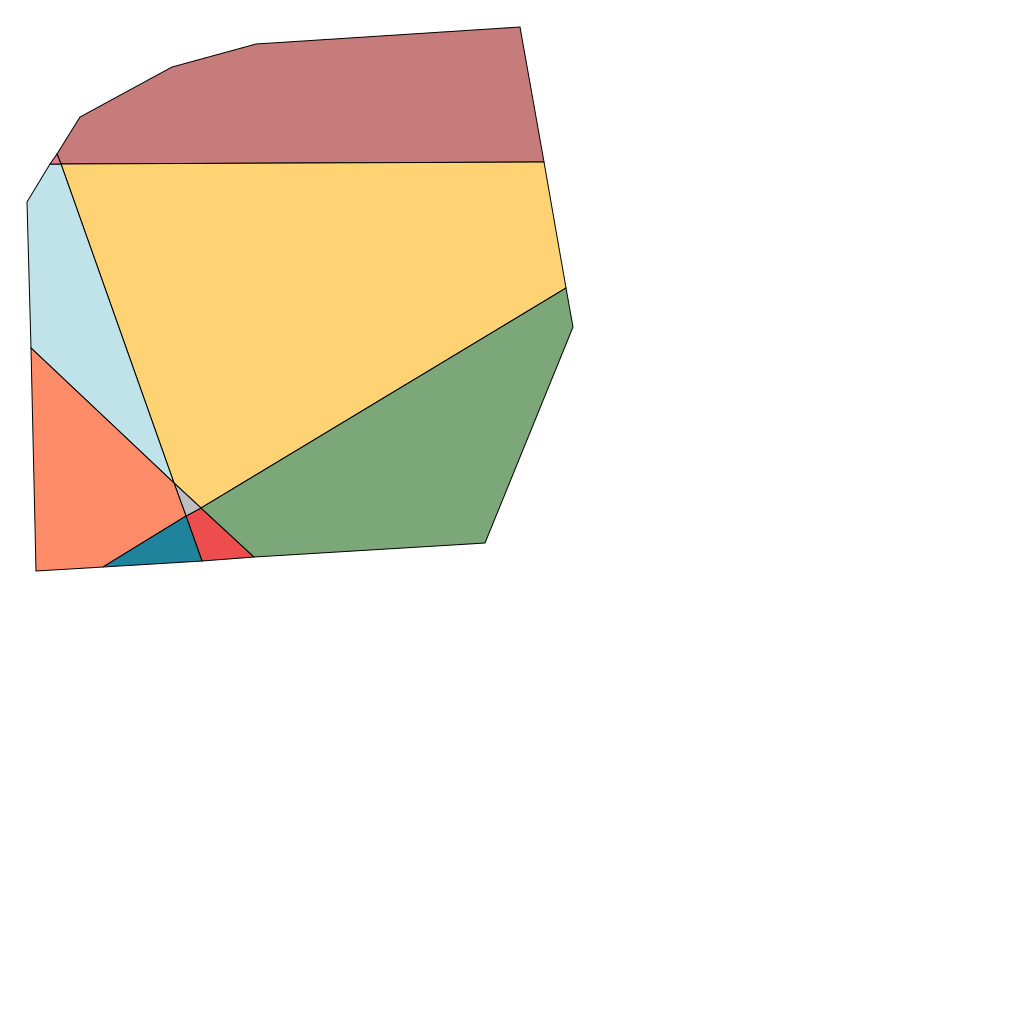

In [ ]:
# load one sample from the dataset
dataset = CrosscutDataset('train', rotation=True, use_image_features=False, data_path='./datasets/puzzlefusion', numSamples=1)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)
batch_sample, conditions = dataloader.__iter__().__next__()
# reshape to required dimensions for base_save_samples
original_sample=batch_sample.unsqueeze(0).permute(0, 1, 3, 2).clone()
base_save_samples(original_sample, None, conditions, True, 0, save_gif=False, save_edges=False, save_svg=False, output_path='puzzlefusion/outputs', nosave=True)


In [9]:
centers, polys, types = calc_centers(original_sample, None, conditions, True, 0, save_gif=False, save_edges=False, save_svg=False, output_path='puzzlefusion/outputs')
graph = construct_graph(centers, polys, center_threshold = 0.8, corner_threshold = 0.05)


    

In [ ]:
#inference with the model
# generate a sample from model checkpoint using the puzzlepieces from a test sample
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
import torch
import imageio
from PIL import Image
from tqdm import tqdm
from puzzlefusion.crosscut_dataset import CrosscutDataset, base_save_samples
from torch.utils.data import DataLoader
import os, sys
sys.path.insert(0, os.getcwd())
sys.path.insert(0, os.getcwd() + "/code")
from gencomp.diffusion.ddpm import DDPM

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize dataset and dataloader
dataset = CrosscutDataset('test', rotation=True, use_image_features=False, data_path='./datasets/puzzlefusion', numSamples=1)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)

# Load a sample from the dataloader and move to device
original_sample, conditions = next(iter(dataloader))
original_sample = original_sample.to(device)
# Move each item in conditions to device (if conditions is a dictionary or similar structure)
conditions = {k: v.to(device) for k, v in conditions.items()}

# Load model and move to device
checkpoint = "experiments/puzzlefusion/best_model_overfit_epoch=499.ckpt"
path = "code/configs/gencomp/puzzlefusion.yaml"
config = OmegaConf.load(path)
model = DDPM.load_from_checkpoint(checkpoint_path=checkpoint, config=path)
model = model.to(device)  # Move model to device
model.eval()

# Sample with the model, ensuring all inputs are on the same device
output = model.sample(batch_size=1, return_intermediates=True, log_every_t=1, **conditions)

# Prepare samples for saving
original_sample = original_sample.unsqueeze(0).permute(0, 1, 3, 2)  # Adjust dimensions as needed
output_sample = output[0].unsqueeze(0).permute(0, 1, 3, 2)
conditions = {k: v.cpu() if isinstance(v, torch.Tensor) else v for k, v in conditions.items()}
# Save samples
base_save_samples(output_sample.cpu(), 'sample', conditions, True, 0, save_edges=True)
base_save_samples(original_sample.cpu(), 'original', conditions, True, 0, save_edges=True)

# Generate frames for the GIF
# frames = []
# for i, img_array in enumerate(tqdm(output[1])):
#     img_array = img_array.unsqueeze(0).permute(0, 1, 3, 2).to(device)  # Ensure each frame is on device
#     img = base_save_samples(img_array.cpu(), 'gif', conditions, True, i, save_edges=True, output_path='./code/puzzlefusion/outputs')
#     frames.append(img)

# # Save the GIF
# frames[0].save('code/puzzlefusion/outputs/sample.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)

data_list = output[1]

Using device: cuda


100%|██████████| 1/1 [00:00<00:00, 249.44it/s]


Numer of samples sampled:  1


loading processed dataset...: 100%|██████████| 1/1 [00:00<00:00, 282.88it/s]


Number of model parameters: 1255364
DiffusionWrapper has 1.26 M params.


Sampling t: 100%|██████████| 1000/1000 [00:11<00:00, 84.34it/s]


In [ ]:
# turn into list of graphs for connected pieces
graph_list = []
print(len(data_list))
for i in range(len(data_list)):
    sample=data_list[i].unsqueeze(0).permute(0, 1, 3, 2).clone().cpu().detach()
    centers, polys, types = calc_centers(sample, None, conditions, True, i, save_gif=False, save_edges=False, save_svg=False, output_path='puzzlefusion/outputs')
    graph = construct_graph(centers, polys, center_threshold = 0.8, corner_threshold = 0.05)
    graph_list.append(graph)

1001


In [ ]:
# remove graphs that are the same as their previous graph
print(len(graph_list))
retention_ratio = remove_consecutive_duplicates(graph_list)
print(len(retention_ratio))

1001
648


In [ ]:
# Evaluation on all metrics
mean_ratio, ratios = edge_retention_ratio_list(retention_ratio)
print(f'Mean edge retention ratio: {mean_ratio}')
print(f'Edge retention ratios: {ratios}')
print(f'Comp score: {comp_score_list(retention_ratio)}')
print(f'Cluster score: {cluster_score(number_of_clusters(retention_ratio[0]), number_of_clusters(retention_ratio[-1]))}')

Mean edge retention ratio: 0.637022521527931
Edge retention ratios: [0.0, 0.0, 1, 0.0, 0.0, 0.0, 0.5, 0.3333333333333333, 0.6, 0.25, 1.0, 0.5, 0.4, 0.16666666666666666, 0.0, 1.0, 0.6666666666666666, 0.2857142857142857, 0.25, 0.75, 0.3333333333333333, 0.2, 0.0, 0.6666666666666666, 0.4, 0.5, 0.0, 0.0, 0.2, 0.25, 0.0, 0.3333333333333333, 0.25, 0.3333333333333333, 0.3333333333333333, 0.0, 1, 0.0, 1, 0.0, 1, 0.5, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 1.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 1.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.3333333333333333, 1.0, 0.5, 0.3333333333333333, 0.0, 0.0, 0.0, 1, 0.0, 0.3333333333333333, 0.0, 1, 0.3333333333333333, 0.5, 0.3333333333333333, 0.0, 1, 0.0, 1, 1.0, 0.5, 1.0, 0.6666666666666666, 0.5, 0.5, 0.0, 1, 0.0, 0.0, 1, 0.5, 0.5, 0.0, 0.5, 0.0, 0.5, 1.0, 0.5, 0.0, 0.6666666666666666, 0.0, 1.0, 0.5, 1.0, 0.0, 1, 0.0, 1.0, 0.5, 0.0, 1, 0.3333333333333333, 1.0, 0.0, 0.0, 1, 1.0, 0.5, 0.5, 0.6666666666666666, 0.6666666666666666, 0.66666666666666

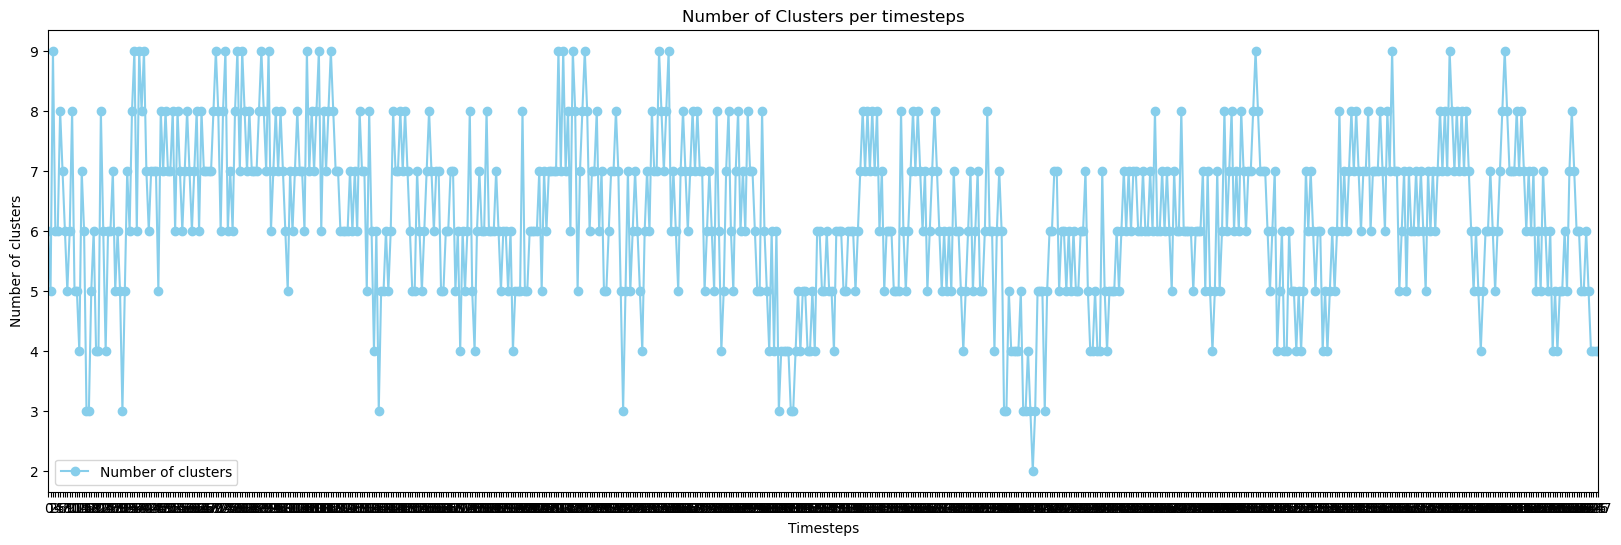

In [ ]:
# Graph number of clusters per timestep
num_edges = [number_of_clusters(G) for G in retention_ratio]

plt.figure(figsize=(20, 6))

plt.plot(range(len(retention_ratio)), num_edges, marker='o', linestyle='-', color='skyblue', label='Number of clusters')
plt.xlabel('Timesteps')
plt.ylabel('Number of clusters')
plt.title('Number of Clusters per timesteps')
plt.xlim([0, len(retention_ratio) - 1])
plt.xticks(range(len(retention_ratio)), [i for i in range(len(retention_ratio))])

# plt.grid(True)
plt.legend()

plt.show()

Construct linear example: add one piece at a time

In [33]:
dataset = CrosscutDataset('train', rotation=True, use_image_features=False, data_path='./datasets/puzzlefusion', numSamples=1)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)
batch_sample, conditions = dataloader.__iter__().__next__()
original_sample=batch_sample.unsqueeze(0).permute(0, 1, 3, 2).clone()
linear_graph = []
def linear_compositionality(sample, timestep=1):
    base_save_samples(sample.clone().unsqueeze(0).permute(0, 1, 3, 2), "linear_comp", conditions, True, 0, save_gif=False, save_edges=False, save_svg=False, output_path='code/puzzlefusion/outputs', nosave=False)
    centers, polys, types = calc_centers(sample.clone().unsqueeze(0).permute(0, 1, 3, 2).clone().cpu().detach(), None, conditions, True, 0, save_gif=False, save_edges=False, save_svg=False, output_path='puzzlefusion/outputs')
    graph = construct_graph(centers, polys, center_threshold = 0.8, corner_threshold = 0.025)
    linear_graph.insert(0, graph)
    start = 0
    for t in range(timestep):
        randint = np.random.rand()*2
        center = sample[0,0,start].clone()
        for i in range(start, sample.shape[-1]):
            if sample[0,0,i] == center:
                sample[0,0,i] = sample[0,0,i] + randint
                sample[0,1,i] = sample[0,1,i] + randint
            else:
                start = i
                break
        base_save_samples(sample.clone().unsqueeze(0).permute(0, 1, 3, 2), "linear_comp", conditions, True, t+1, save_gif=False, save_edges=False, save_svg=False, output_path='code/puzzlefusion/outputs', nosave=False)
        centers, polys, types = calc_centers(sample.clone().unsqueeze(0).permute(0, 1, 3, 2).clone().cpu().detach(), None, conditions, True, i+1, save_gif=False, save_edges=False, save_svg=False, output_path='puzzlefusion/outputs')
        graph = construct_graph(centers, polys, center_threshold = 0.8, corner_threshold = 0.025)
        linear_graph.insert(0, graph)
    return sample

l =linear_compositionality(batch_sample.clone(), timestep=9)
# for im in range(9):
#     t_1 = linear_compositionality(batch_sample.clone(), timestep=im).unsqueeze(0).permute(0, 1, 3, 2)
#     base_save_samples(t_1, "linear_comp", conditions, True, im, save_gif=False, save_edges=False, save_svg=False, output_path='code/puzzlefusion/outputs', nosave=False)

print(len(linear_graph))
linear_retention_ratio = remove_consecutive_duplicates(linear_graph)
print(len(linear_retention_ratio))

100%|██████████| 1/1 [00:00<00:00, 207.82it/s]


Numer of samples sampled:  1


loading processed dataset...: 100%|██████████| 1/1 [00:00<00:00, 276.12it/s]


10
7


In [34]:
mean_ratio, ratios = edge_retention_ratio_list(linear_retention_ratio)
print(f'Mean edge retention ratio: {mean_ratio}')
print(f'Edge retention ratios: {ratios}')
print(f'Comp score: {comp_score_list(linear_retention_ratio)}')
print(f'Cluster score: {cluster_score(number_of_clusters(linear_retention_ratio[0]), number_of_clusters(linear_retention_ratio[-1]))}')

Mean edge retention ratio: 0.8333333333333334
Edge retention ratios: [0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Comp score: (0.8125, [-0.125, 1, 1, 1, 1, 1])
Cluster score: 1.0


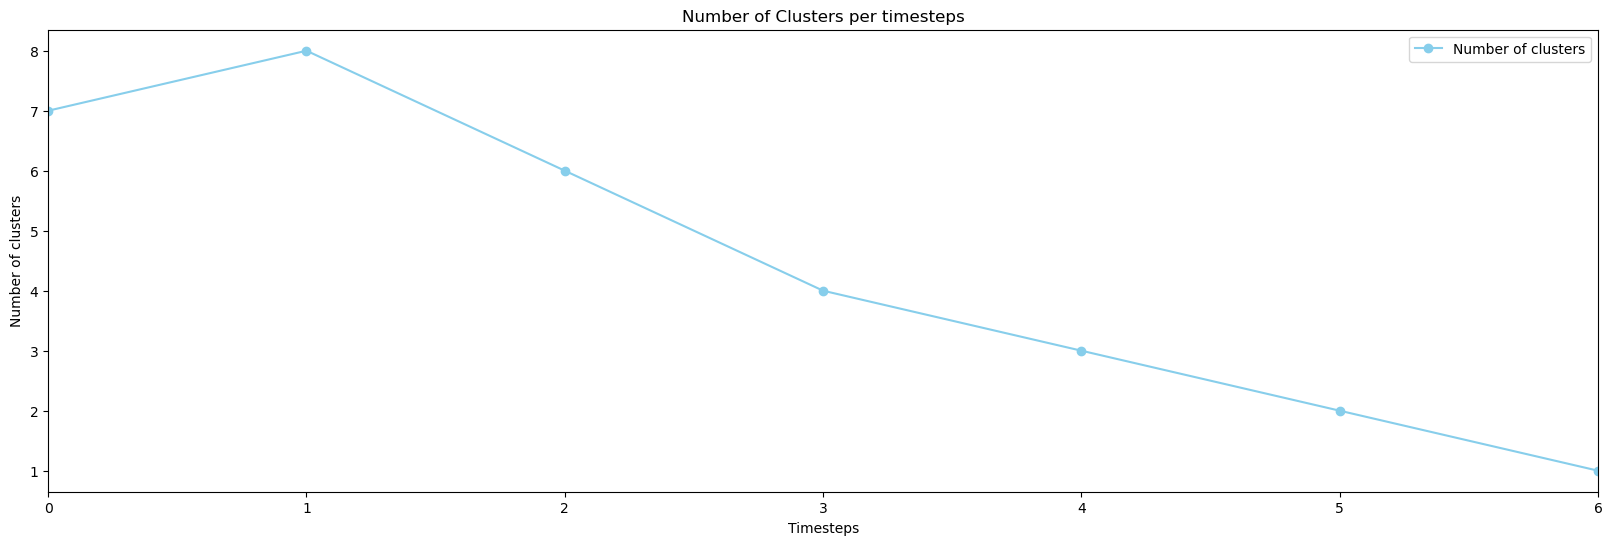

In [35]:
num_edges = [number_of_clusters(G) for G in linear_retention_ratio]

plt.figure(figsize=(20, 6))

plt.plot(range(len(linear_retention_ratio)), num_edges, marker='o', linestyle='-', color='skyblue', label='Number of clusters')
plt.xlabel('Timesteps')
plt.ylabel('Number of clusters')
plt.title('Number of Clusters per timesteps')
plt.xlim([0, len(linear_retention_ratio) - 1])
plt.xticks(range(len(linear_retention_ratio)), [i for i in range(len(linear_retention_ratio))])

# plt.grid(True)
plt.legend()

plt.show()

Construct merge example: Pair up puzzle pieces unitl sovled

In [115]:
merge_graph_list = []
def div_compositionality(sample, timestep=1):
    base_save_samples(sample.clone().unsqueeze(0).permute(0, 1, 3, 2), "div_comp", conditions, True, 0, save_gif=False, save_edges=False, save_svg=False, output_path='code/puzzlefusion/outputs', nosave=False)
    centers, polys, types = calc_centers(sample.clone().unsqueeze(0).permute(0, 1, 3, 2).clone().cpu().detach(), None, conditions, True, 0, save_gif=False, save_edges=False, save_svg=False, output_path='puzzlefusion/outputs')
    merge_graph_list.insert(0, construct_graph(centers, polys, center_threshold = 0.8, corner_threshold = 0.05))
    
    randint = np.random.rand()*2
    #lvl 1
    # move 1 2 4 6
    sample[0,0:2,4:11] += randint # 1
    sample[0,0:2,11:16] += randint # 2
    sample[0,0:2,19:24] += randint # 4
    sample[0,0:2,29:32] += randint # 6
    base_save_samples(sample.clone().unsqueeze(0).permute(0, 1, 3, 2), "div_comp", conditions, True, 1, save_gif=False, save_edges=False, save_svg=False, output_path='code/puzzlefusion/outputs', nosave=False)
    centers, polys, types = calc_centers(sample.clone().unsqueeze(0).permute(0, 1, 3, 2).clone().cpu().detach(), None, conditions, True, 1, save_gif=False, save_edges=False, save_svg=False, output_path='puzzlefusion/outputs')
    merge_graph_list.insert(0, construct_graph(centers, polys, center_threshold = 0.8, corner_threshold = 0.05))
    
    #lvl 2
    # move 6 4
    randint = np.random.rand()
    sample[0,0:2,19:24] += randint # 4
    sample[0,0:2,29:32] += randint # 6
    #move 0 5
    randint = np.random.rand()
    sample[0,0:2,0:4] += randint # 0
    sample[0,0:2,24:29] += randint # 5
    base_save_samples(sample.clone().unsqueeze(0).permute(0, 1, 3, 2), "div_comp", conditions, True, 2, save_gif=False, save_edges=False, save_svg=False, output_path='code/puzzlefusion/outputs', nosave=False)
    centers, polys, types = calc_centers(sample.clone().unsqueeze(0).permute(0, 1, 3, 2).clone().cpu().detach(), None, conditions, True, 2, save_gif=False, save_edges=False, save_svg=False, output_path='puzzlefusion/outputs')
    merge_graph_list.insert(0, construct_graph(centers, polys, center_threshold = 0.8, corner_threshold = 0.05))

    # lvl 3
    # move 8
    randint = np.random.rand()
    sample[0,0:2,37:40] += randint # 8
    # move 5
    randint = np.random.rand()
    sample[0,0:2,24:29] += randint # 5
    # move 1
    randint = np.random.rand()
    sample[0,0:2,4:11] += randint # 1
    # move 4
    randint = np.random.rand()
    sample[0,0:2,19:24] += randint # 4
    base_save_samples(sample.clone().unsqueeze(0).permute(0, 1, 3, 2), "div_comp", conditions, True, 3, save_gif=False, save_edges=False, save_svg=False, output_path='code/puzzlefusion/outputs', nosave=False)
    centers, polys, types = calc_centers(sample.clone().unsqueeze(0).permute(0, 1, 3, 2).clone().cpu().detach(), None, conditions, True, 3, save_gif=False, save_edges=False, save_svg=False, output_path='puzzlefusion/outputs')
    merge_graph_list.insert(0, construct_graph(centers, polys, center_threshold = 0.8, corner_threshold = 0.05))

    # lvl 4
    #move 3
    randint = np.random.rand()
    sample[0,0:2,16:19] += randint # 3
    base_save_samples(sample.clone().unsqueeze(0).permute(0, 1, 3, 2), "div_comp", conditions, True, 4, save_gif=False, save_edges=False, save_svg=False, output_path='code/puzzlefusion/outputs', nosave=False)
    centers, polys, types = calc_centers(sample.clone().unsqueeze(0).permute(0, 1, 3, 2).clone().cpu().detach(), None, conditions, True, 4, save_gif=False, save_edges=False, save_svg=False, output_path='puzzlefusion/outputs')
    merge_graph_list.insert(0, construct_graph(centers, polys, center_threshold = 0.8, corner_threshold = 0.05))
    return sample

d = div_compositionality(batch_sample.clone(), timestep=9)
# base_save_samples(d.clone().unsqueeze(0).permute(0, 1, 3, 2), "linear_comp", conditions, True, 0, save_gif=False, save_edges=False, save_svg=False, output_path='code/puzzlefusion/outputs', nosave=True)

In [116]:
print(len(merge_graph_list))
merge_retention_ratio = remove_consecutive_duplicates(merge_graph_list)
print(len(merge_retention_ratio))

5
5


In [117]:
mean_ratio, ratios = edge_retention_ratio_list(merge_retention_ratio)
print(f'Mean edge retention ratio: {mean_ratio}')
print(f'Edge retention ratios: {ratios}')
print(f'Comp score: {comp_score_list(merge_retention_ratio)}')
print(f'Cluster score: {cluster_score(number_of_clusters(merge_retention_ratio[0]), number_of_clusters(merge_retention_ratio[-1]))}')

Mean edge retention ratio: 1.0
Edge retention ratios: [1.0, 1.0, 1.0, 1.0]
Comp score: (1.0, [1, 1, 1, 1])
Cluster score: 1.0


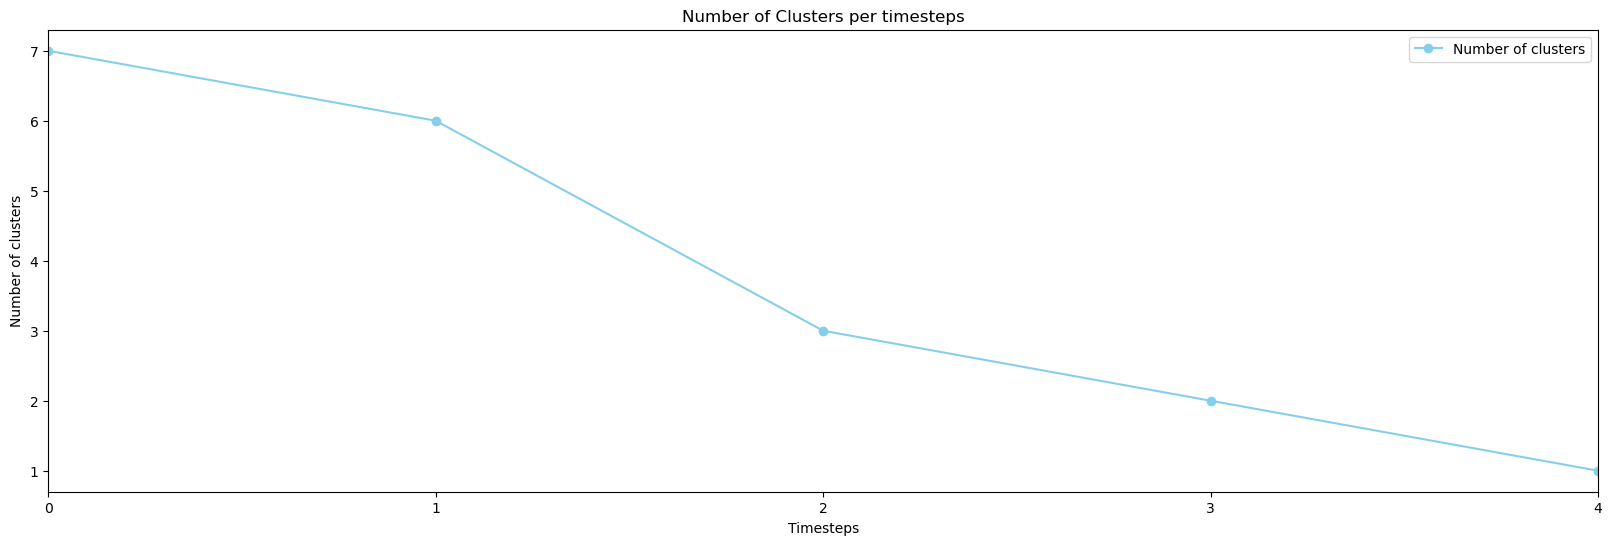

In [118]:
num_edges = [number_of_clusters(G) for G in merge_retention_ratio]

plt.figure(figsize=(20, 6))

plt.plot(range(len(merge_retention_ratio)), num_edges, marker='o', linestyle='-', color='skyblue', label='Number of clusters')
plt.xlabel('Timesteps')
plt.ylabel('Number of clusters')
plt.title('Number of Clusters per timesteps')
plt.xlim([0, len(merge_retention_ratio) - 1])
plt.xticks(range(len(merge_retention_ratio)), [i for i in range(len(merge_retention_ratio))])

# plt.grid(True)
plt.legend()

plt.show()

Construct random noise example: reverse process of adding steps of noise to ground truth.

In [146]:
nc_graph_list = []
def non_comp(sample, num_pieces=9, num_graphs=6):
    base_save_samples(sample.clone().unsqueeze(0).permute(0, 1, 3, 2), "non_comp", conditions, True, 0, save_gif=False, save_edges=False, save_svg=False, output_path='code/puzzlefusion/outputs', nosave=False)
    centers, polys, types = calc_centers(sample.clone().unsqueeze(0).permute(0, 1, 3, 2).clone().cpu().detach(), None, conditions, True, 0, save_gif=False, save_edges=False, save_svg=False, output_path='puzzlefusion/outputs')
    nc_graph_list.insert(0, construct_graph(centers, polys, center_threshold = 0.8, corner_threshold = 0.025))
    
    # randint = np.random.rand()*2
    # sample[0,0,0:24] += randint

    # base_save_samples(sample.clone().unsqueeze(0).permute(0, 1, 3, 2), "non_comp", conditions, True, 1, save_gif=False, save_edges=False, save_svg=False, output_path='code/puzzlefusion/outputs', nosave=False)
    # centers, polys, types = calc_centers(sample.clone().unsqueeze(0).permute(0, 1, 3, 2).clone().cpu().detach(), None, conditions, True, 0, save_gif=False, save_edges=False, save_svg=False, output_path='puzzlefusion/outputs')
    # nc_graph_list.insert(0, construct_graph(centers, polys, center_threshold = 0.8, corner_threshold = 0.05))
    for g in range(num_graphs):
        start=0
        for p in range(num_pieces):
            randint = np.random.rand()*2-1
            center = sample[0,0,start].clone()
            for i in range(start, sample.shape[-1]):
                if sample[0,0,i] == center:
                    sample[0,0,i] = sample[0,0,i] + randint
                    sample[0,1,i] = sample[0,1,i] + randint
                else:
                    start = i
                    break

        base_save_samples(sample.clone().unsqueeze(0).permute(0, 1, 3, 2), "non_comp", conditions, True, g+1, save_gif=False, save_edges=False, save_svg=False, output_path='code/puzzlefusion/outputs', nosave=False)
        centers, polys, types = calc_centers(sample.clone().unsqueeze(0).permute(0, 1, 3, 2).clone().cpu().detach(), None, conditions, True, g+1, save_gif=False, save_edges=False, save_svg=False, output_path='puzzlefusion/outputs')
        nc_graph_list.insert(0, construct_graph(centers, polys, center_threshold = 0.8, corner_threshold = 0.025))
    return sample

nc = non_comp(batch_sample.clone())

In [147]:
print(len(nc_graph_list))
nc_retention_ratio = remove_consecutive_duplicates(nc_graph_list)
print(len(nc_retention_ratio))

7
6


In [148]:
mean_ratio, ratios = edge_retention_ratio_list(nc_retention_ratio)
print(f'Mean edge retention ratio: {mean_ratio}')
print(f'Edge retention ratios: {ratios}')
print(f'Comp score: {comp_score_list(nc_retention_ratio)}')
print(f'Cluster score: {cluster_score(number_of_clusters(nc_retention_ratio[0]), number_of_clusters(nc_retention_ratio[-1]))}')

Mean edge retention ratio: 0.4
Edge retention ratios: [0.5, 1.0, 0.0, 0.0, 0.5]
Comp score: (0.3571428571428571, [0.0, 1, -0.5, 1, 0.2857142857142857])
Cluster score: 1.0


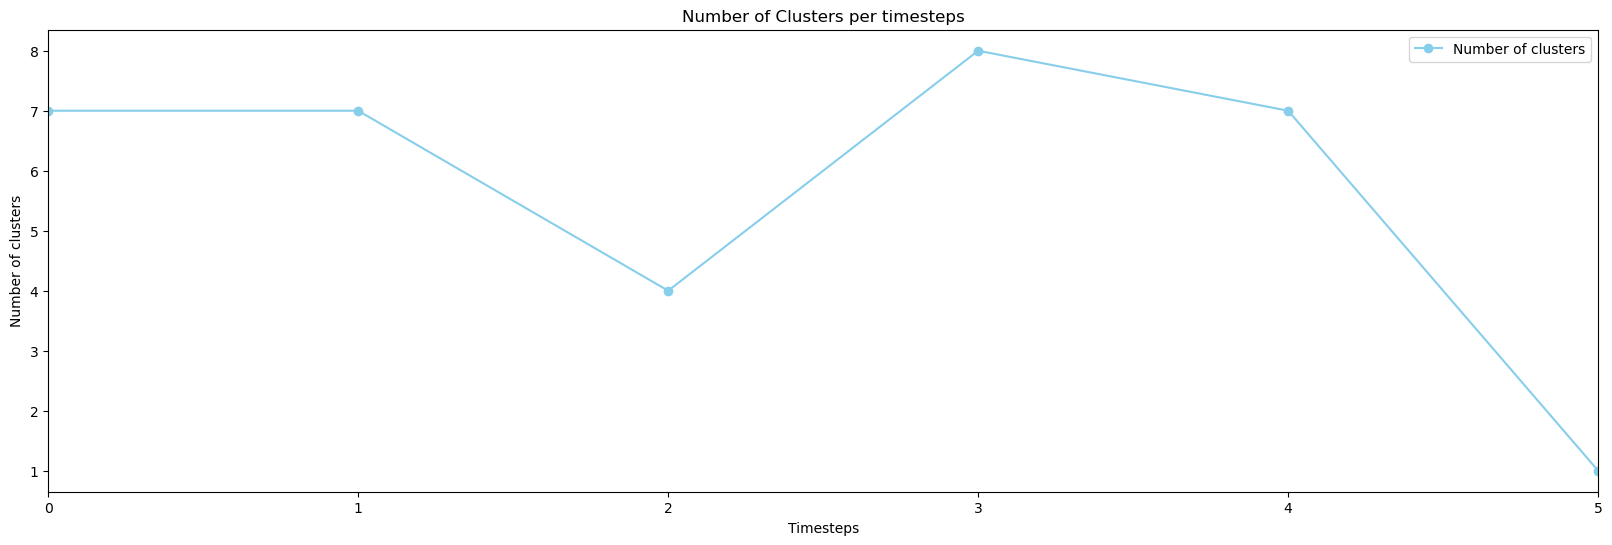

In [149]:
num_edges = [number_of_clusters(G) for G in nc_retention_ratio]

plt.figure(figsize=(20, 6))

plt.plot(range(len(nc_retention_ratio)), num_edges, marker='o', linestyle='-', color='skyblue', label='Number of clusters')
plt.xlabel('Timesteps')
plt.ylabel('Number of clusters')
plt.title('Number of Clusters per timesteps')
plt.xlim([0, len(nc_retention_ratio) - 1])
plt.xticks(range(len(nc_retention_ratio)), [i for i in range(len(nc_retention_ratio))])

# plt.grid(True)
plt.legend()

plt.show()

Other data types, not currently implemented in framework

Voronoi:
- One file per puzzle data\_\[puzzle number].json
- Dictionary of regions where  key is region indices and value is list of vertices
- variable number of regions and vertices per region

In [9]:
with open('../datasets/puzzlefusion/samples/Voronoi_samples/p2/data_434.json') as f:
    d = json.load(f)
    print(d)

{'0': [1540, 1205], '1': [[[537, 855]], [[681, 1265]], [[920, 1325]], [[1168, 867]]], '2': [[[410, 738]], [[197, 1272]], [[508, 1420]], [[680, 1264]], [[537, 856]]], '3': [[[401, 746]], [[0, 872]], [[0, 1361]], [[196, 1272]]], '4': [[[0, 0]], [[0, 311]], [[210, 365]], [[338, 0]]], '5': [[[1204, 842]], [[1168, 868]], [[923, 1326]], [[1035, 1539]], [[1204, 1539]]], '6': [[[509, 1420]], [[497, 1539]], [[1034, 1539]], [[922, 1326]], [[684, 1266]]], '7': [[[415, 577]], [[411, 737]], [[536, 854]], [[1169, 867]], [[1204, 841]], [[1203, 598]], [[609, 446]]], '8': [[[0, 312]], [[0, 871]], [[406, 741]], [[400, 561]], [[211, 366]]], '9': [[[807, 0]], [[609, 445]], [[1204, 598]], [[1204, 0]]], '10': [[[0, 1362]], [[0, 1539]], [[497, 1538]], [[507, 1420]], [[198, 1273]]], '11': [[[806, 0]], [[339, 0]], [[211, 365]], [[417, 575]], [[608, 446]]]}


Magic Plan:
- Single-story floor plans
- Each room has its own file: \[house number]\_\[room number].npz
- Each file is 256x256 array where values of 0 represent the background and discrete values represent room type.

room_array
(256, 256)


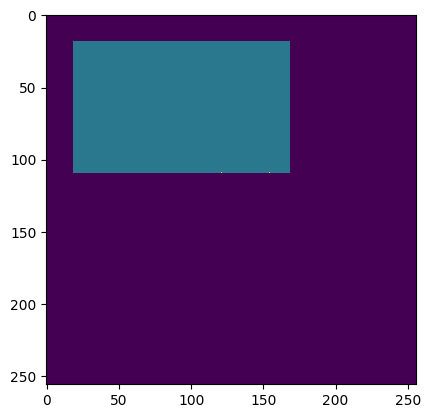

In [11]:
with np.load('../datasets/puzzlefusion/samples/MagicPlan_samples/p0/1_2.npz') as data:
    lst = data.files
    for item in lst:
        print(item)
        print(data[item].shape)
        plt.imshow(data[item], interpolation='nearest')
        plt.show()

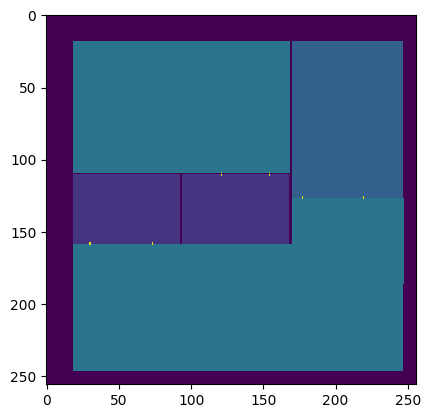

In [12]:
num_rooms = 5
image = np.zeros((256,256))
for i in range(num_rooms):
    room = np.load(f'../datasets/puzzlefusion/samples/MagicPlan_samples/p0/1_{i}.npz')
    image += room[room.files[0]]
plt.imshow(image, interpolation='nearest')
plt.show()